In [23]:
#import libraries
# This ensures visualizations are plotted inside the notebook
%matplotlib inline
import io
import os              # This provides several system utilities
import pandas as pd    
import seaborn as sns 
import numpy as np
import rtree
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
from cenpy import products
import cenpy
import scipy.stats  as stats # low-level stats & probability
import statsmodels.formula.api as smf # high-level stats
import requests
import contextily as ctx
import rasterio as rio
import pysal as ps

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [5]:
# #reproduce paper data
# austria_shp = gpd.read_file('NUTS_BN_60M_2006_4326_LEVL_2.shp')
# austria_shp.plot(figsize=(20,20))

# austria = pd.read_csv('AT_Austria.csv')
# austria.head()

In [6]:
# #download once
# import requests, zipfile, io
# r = requests.get('https://s3.amazonaws.com/tripdata/201905-citibike-tripdata.csv.zip')
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall('biketrip.csv')

In [2]:
bike_data = pd.read_csv('biketrip.csv/201905-citibike-tripdata.csv')

In [3]:
# download from https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv
taxi_data = pd.read_csv('yellow_tripdata_2019-05.csv')

In [4]:
bike_data.size

28868445

In [5]:
bike_data.head()
bike_data["starttime"] = pd.to_datetime(bike_data["starttime"])
bike_data["stoptime"] = pd.to_datetime(bike_data["stoptime"])
bike_data["hour"] = bike_data["starttime"].map(lambda x: x.hour)

In [4]:
taxi_data.size

136174698

In [7]:
# data preprocessing -- groupby stations to get departure, arrival counts and lat/lng
def get_biketrip_counts_by_hour(selected_hour):
    # make a DataFrame with locations for each bike station
    locations = bike_data.groupby("start station id").first()
    locations = locations.loc[:, ["start station latitude",
                                 "start station longitude",
                                 "start station name"]]
    
    #select one time of day
    subset = bike_data[bike_data["hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("start station id").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("end station id").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

# print a sample to check our code works
get_biketrip_counts_by_hour(6).head()

,Departure Count,start station latitude,start station longitude,start station name,Arrival Count
start station id,,,,,
72,52,40.767272,-73.993929,W 52 St & 11 Ave,104.0
79,24,40.719116,-74.006667,Franklin St & W Broadway,60.0
82,40,40.711174,-74.000165,St James Pl & Pearl St,18.0
83,12,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,55.0
119,9,40.696089,-73.978034,Park Ave & St Edwards St,21.0


In [8]:
# subset data for time between 5:00-6:00am
sample_biketrip = get_biketrip_counts_by_hour(6)

sample_biketrip.head()

,Departure Count,start station latitude,start station longitude,start station name,Arrival Count
start station id,,,,,
72,52,40.767272,-73.993929,W 52 St & 11 Ave,104.0
79,24,40.719116,-74.006667,Franklin St & W Broadway,60.0
82,40,40.711174,-74.000165,St James Pl & Pearl St,18.0
83,12,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,55.0
119,9,40.696089,-73.978034,Park Ave & St Edwards St,21.0


In [93]:
#generate geodataframe
gdf_biketrip = gpd.GeoDataFrame(
    sample_biketrip, 
    geometry=gpd.points_from_xy(sample_biketrip['start station longitude'], 
                                sample_biketrip['start station latitude']))
gdf_biketrip.crs = {'init' :'epsg:4326'}
gdf_biketrip.head()
gdf_biketrip = gdf_biketrip.to_crs({'init':'epsg:3857'})

# buffer bike stations
gdf_biketrip_200 = gdf_biketrip.buffer(200)
gdf_biketrip_200.head()

start station id
72     POLYGON ((-8236766.4847153 4978074.727920331, ...
79     POLYGON ((-8238184.44233276 4970999.131063734,...
82     POLYGON ((-8237460.736511995 4969832.808450633...
83     POLYGON ((-8234806.638288189 4965817.33985417,...
119    POLYGON ((-8234997.091465402 4967617.741565764...
dtype: object

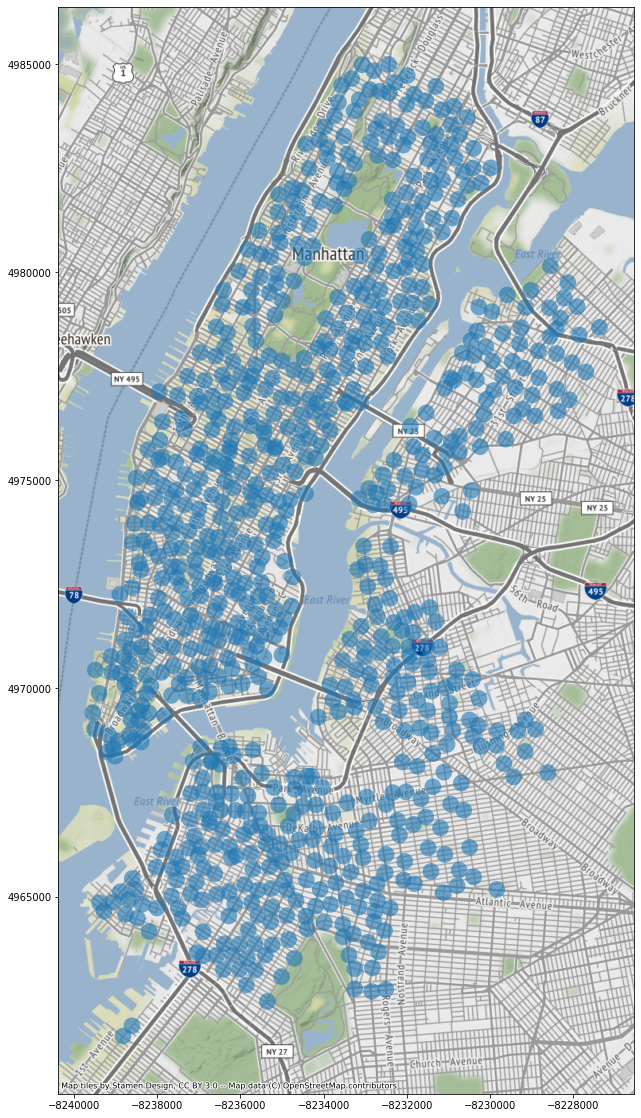

In [98]:
f, ax = plt.subplots(1,1,figsize=(20,20))
gdf_biketrip_200.plot(ax=ax,alpha = 0.6)
ctx.add_basemap(ax);
plt.savefig('bikestations.png')

In [6]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-05-01 00:14:50,2019-05-01 00:16:48,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.0,0.0,0.3,4.3,0.0
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.5,1,N,145,145,2,3.0,0.5,0.5,0.0,0.0,0.3,4.3,0.0
2,1,2019-05-01 00:37:45,2019-05-01 00:37:49,1,1.5,1,N,145,145,2,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.7,1,N,161,161,2,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.0,1,N,163,141,1,9.5,3.0,0.5,2.0,0.0,0.3,15.3,2.5


In [7]:
taxi_data.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [8]:
taxi_data["pickuptime"] = pd.to_datetime(taxi_data["tpep_pickup_datetime"])
taxi_data["dropofftime"] = pd.to_datetime(taxi_data["tpep_dropoff_datetime"])
taxi_data["hour"] = taxi_data["pickuptime"].map(lambda x: x.hour)
taxi_data["weekday"] = taxi_data["pickuptime"].map(lambda x: x.weekday)

In [9]:
taxi_data["weekday_name"] = taxi_data["pickuptime"].map(lambda x: x.day_name)
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickuptime,dropofftime,hour,weekday,weekday_name
0,1,2019-05-01 00:14:50,2019-05-01 00:16:48,1,0.0,1,N,145,145,2,...,0.0,0.0,0.3,4.3,0.0,2019-05-01 00:14:50,2019-05-01 00:16:48,0,<built-in method weekday of Timestamp object a...,<bound method Timestamp.day_name of Timestamp(...
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.5,1,N,145,145,2,...,0.0,0.0,0.3,4.3,0.0,2019-05-01 00:35:54,2019-05-01 00:37:27,0,<built-in method weekday of Timestamp object a...,<bound method Timestamp.day_name of Timestamp(...
2,1,2019-05-01 00:37:45,2019-05-01 00:37:49,1,1.5,1,N,145,145,2,...,0.0,0.0,0.3,3.8,0.0,2019-05-01 00:37:45,2019-05-01 00:37:49,0,<built-in method weekday of Timestamp object a...,<bound method Timestamp.day_name of Timestamp(...
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.7,1,N,161,161,2,...,0.0,0.0,0.3,8.8,2.5,2019-05-01 00:44:57,2019-05-01 00:50:11,0,<built-in method weekday of Timestamp object a...,<bound method Timestamp.day_name of Timestamp(...
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.0,1,N,163,141,1,...,2.0,0.0,0.3,15.3,2.5,2019-05-01 00:59:48,2019-05-01 01:10:22,0,<built-in method weekday of Timestamp object a...,<bound method Timestamp.day_name of Timestamp(...


In [10]:
taxi_lite = taxi_data[['PULocationID','DOLocationID','trip_distance','pickuptime','dropofftime','hour','weekday_name']]
taxi_lite.head()

,PULocationID,DOLocationID,trip_distance,pickuptime,dropofftime,hour,weekday_name
0,145,145,0.0,2019-05-01 00:14:50,2019-05-01 00:16:48,0,<bound method Timestamp.day_name of Timestamp(...
1,145,145,1.5,2019-05-01 00:35:54,2019-05-01 00:37:27,0,<bound method Timestamp.day_name of Timestamp(...
2,145,145,1.5,2019-05-01 00:37:45,2019-05-01 00:37:49,0,<bound method Timestamp.day_name of Timestamp(...
3,161,161,0.7,2019-05-01 00:44:57,2019-05-01 00:50:11,0,<bound method Timestamp.day_name of Timestamp(...
4,163,141,2.0,2019-05-01 00:59:48,2019-05-01 01:10:22,0,<bound method Timestamp.day_name of Timestamp(...


In [11]:
#10/29 make week dataset
week_mask = (taxi_lite['pickuptime'] >= '2019-5-6') & (taxi_lite['pickuptime'] < '2019-5-13')
sampleweek_taxi_lite = taxi_lite.loc[week_mask]
sampleweek_taxi_lite

,PULocationID,DOLocationID,trip_distance,pickuptime,dropofftime,hour,weekday_name
1320227,161,79,2.64,2019-05-06 00:00:27,2019-05-06 00:10:01,0,<bound method Timestamp.day_name of Timestamp(...
1320384,230,170,1.09,2019-05-06 00:00:33,2019-05-06 00:06:17,0,<bound method Timestamp.day_name of Timestamp(...
1320415,100,263,3.18,2019-05-06 00:00:15,2019-05-06 00:13:47,0,<bound method Timestamp.day_name of Timestamp(...
1321124,132,197,6.88,2019-05-06 00:01:25,2019-05-06 00:14:15,0,<bound method Timestamp.day_name of Timestamp(...
1321175,7,252,8.21,2019-05-06 00:02:51,2019-05-06 00:18:27,0,<bound method Timestamp.day_name of Timestamp(...
...,...,...,...,...,...,...,...
3345182,237,87,6.71,2019-05-12 21:55:58,2019-05-12 22:19:56,21,<bound method Timestamp.day_name of Timestamp(...
3359081,209,87,0.61,2019-05-12 22:31:03,2019-05-12 22:38:16,22,<bound method Timestamp.day_name of Timestamp(...
3359082,231,87,0.49,2019-05-12 22:49:52,2019-05-12 22:58:48,22,<bound method Timestamp.day_name of Timestamp(...
3372496,261,43,6.22,2019-05-12 23:05:41,2019-05-12 23:50:51,23,<bound method Timestamp.day_name of Timestamp(...


In [66]:

hour_si = pd.DataFrame({'count' : sampleweek_taxi_lite.groupby(['PULocationID','DOLocationID','hour'] ).size()}).reset_index()
hour_si = hour_si[hour_si['PULocationID']!=hour_si['DOLocationID']]
hour_si = hour_si[ (hour_si['PULocationID']<264) & (hour_si['DOLocationID']<264)]
hour_si

,PULocationID,DOLocationID,hour,count
20,1,138,4,1
39,2,68,15,1
40,2,261,12,1
45,3,32,11,1
46,3,39,4,1
...,...,...,...,...
137805,263,262,19,108
137806,263,262,20,102
137807,263,262,21,122
137808,263,262,22,64


In [27]:

thresh = ps.lib.weights.min_threshold_dist_from_shapefile("taxi_zones/taxi_zones.shp")
thresh

22129.82874885107

In [42]:
taxi_zone = gpd.read_file('taxi_zones/taxi_zones.shp')
taxi_zone

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.781960189 270986.1393638253,..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966050446 216463.0052037984,..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.2043112218 196138.486258477, ..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,(POLYGON ((999804.7945504487 224498.5270484537...


In [52]:
centroids =  ps.lib.weights.get_points_array_from_shapefile("taxi_zones/taxi_zones.shp")

dist_mat = ps.lib.cg.distance_matrix(centroids)
dist_mat

array([[     0.        ,  98946.23965342, 110169.15745893, ...,
         45079.23812559,  70098.33653865,  69442.47252368],
       [ 98946.23965342,      0.        ,  90365.57348043, ...,
         60620.81681361,  66213.29907164,  67721.78543112],
       [110169.15745893,  90365.57348043,      0.        , ...,
         72841.1424919 ,  42341.59098165,  42392.2353118 ],
       ...,
       [ 45079.23812559,  60620.81681361,  72841.1424919 , ...,
             0.        ,  30526.81544231,  30639.4506663 ],
       [ 70098.33653865,  66213.29907164,  42341.59098165, ...,
         30526.81544231,      0.        ,   1618.23878604],
       [ 69442.47252368,  67721.78543112,  42392.2353118 , ...,
         30639.4506663 ,   1618.23878604,      0.        ]])

In [69]:
for i, row in hour_si.iterrows():
    hour_si.at[i,'Dij'] = dist_mat[int(row['PULocationID']-1)][int(row['DOLocationID']-1)]

In [123]:
hour1 = hour_si[hour_si['hour'] == 1]

In [116]:
res_do = pd.DataFrame(hour1.groupby('DOLocationID')['count'].count())
res_do['hour'] = 1 * np.ones(res_do.shape)
res_do.astype({'hour': 'int32'}).dtypes
res_do = res_do.astype({'hour': 'int32'})
res_do = res_do.rename(columns = {'count':'Dj'})
res_do

,Dj,hour
DOLocationID,,
1,3,1
3,4,1
4,49,1
7,55,1
9,2,1
...,...,...
259,8,1
260,41,1
261,39,1


In [117]:
res_pu = pd.DataFrame(hour1.groupby('PULocationID')['count'].count())
res_pu['hour'] = 1 * np.ones(res_pu.shape)
res_pu = res_pu.astype({'hour': 'int32'})
res_pu = res_pu.rename(columns = {'count':'Oi'})
res_pu

,Oi,hour
PULocationID,,
3,2,1
4,57,1
7,27,1
10,5,1
11,2,1
...,...,...
257,2,1
260,18,1
261,53,1


In [125]:
hour1_O = pd.merge(hour1, res_pu,how = 'left',on=['PULocationID', 'hour'])
hour1_OD = pd.merge(hour1_O, res_do,how = 'left',on=['DOLocationID', 'hour'])
hour1_OD = hour1_OD.rename(columns={'count':'flow'})
hour1_OD

,PULocationID,DOLocationID,hour,flow,Dij,Oi,Dj
0,3,185,1,1,4144.520643,2,8
1,3,246,1,1,59325.695103,2,52
2,4,17,1,1,13939.575208,57,42
3,4,25,1,4,14117.261038,57,44
4,4,36,1,1,18480.219894,57,43
...,...,...,...,...,...,...,...
5288,263,249,1,1,21579.382871,81,51
5289,263,255,1,2,21918.064509,81,46
5290,263,259,1,1,51306.244867,81,8
5291,263,260,1,3,17653.473690,81,41


In [158]:
df = pd.DataFrame()
for hr in range(24):
    hour1 = hour_si[hour_si['hour'] == hr]
    
    res_do = pd.DataFrame(hour1.groupby('DOLocationID')['count'].count())
    res_do['hour'] = hr * np.ones(res_do.shape)
    res_do = res_do.astype({'hour': 'int32'})
    res_do = res_do.rename(columns = {'count':'Dj'})
    
    res_pu = pd.DataFrame(hour1.groupby('PULocationID')['count'].count())
    res_pu['hour'] = hr * np.ones(res_pu.shape)
    res_pu = res_pu.astype({'hour': 'int32'})
    res_pu = res_pu.rename(columns = {'count':'Oi'})
    
    hour1_O = pd.merge(hour1, res_pu,how = 'left',on=['PULocationID', 'hour'])
    hour1_OD = pd.merge(hour1_O, res_do,how = 'left',on=['DOLocationID', 'hour'])
    hour1_OD = hour1_OD.rename(columns={'count':'flow'})
    #print(hour1_OD.head())
    df = df.append(hour1_OD)
df

,PULocationID,DOLocationID,hour,flow,Dij,Oi,Dj
0,4,13,0,1,11651.582881,60,45
1,4,25,0,1,14117.261038,60,51
2,4,37,0,2,18439.683952,60,46
3,4,40,0,1,17064.512022,60,43
4,4,41,0,2,30207.906232,60,59
...,...,...,...,...,...,...,...
6646,263,248,23,1,29703.903888,91,14
6647,263,249,23,7,21579.382871,91,59
6648,263,256,23,3,24855.433995,91,59
6649,263,260,23,1,17653.473690,91,45


In [176]:
#TODO: generate sequence data with sample of X: 24*1*3(Dij,Oi,Dj) and Y:24*1*1(flow)
# find (PU,DO) that has hour [0,...,23]
grouped = df.groupby(['PULocationID','DOLocationID'])

df2 = grouped.aggregate(lambda x: np.array(x))
df2

hour  \
PULocationID DOLocationID                                                      
1            138                                                           4   
2            68                                                           15   
             261                                                          12   
3            32                                                           11   
             39                                                            4   
...                                                                      ...   
263          258                                                          21   
             259                                                  [1, 4, 18]   
             260              [0, 1, 3, 4, 5, 8, 11, 12, 13, 20, 21, 22, 23]   
             261           [0, 2, 5, 6, 8, 9, 10, 11, 12, 14, 15, 17, 19,...   
             262           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                                                        flow  \
PULocationID DOLocationID                                                      
1            138                                                           1   
2            68                                                            1   
             261                                                           1   
3            32                                                            1   
             39                                                            1   
...                                                                      ...   
263          258                                                           1   
             259                                                   [1, 1, 1]   
             260                     [4, 3, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1]   
             261                  [1, 1, 1, 3, 5, 4, 3, 2, 1, 6, 2, 1, 1, 1]   
             262           [14, 18, 12, 4, 3, 7, 14, 32, 58, 67, 80, 83, ...   

                                                                         Dij  \
PULocationID DOLocationID                                                      
1            138                                                     88512.1   
2            68                                                      66998.1   
             261                                                     60620.8   
3            32                                                      4837.74   
             39                                                      83761.9   
...                                                                      ...   
263          258                                                     42106.7   
             259           [51306.244866541856, 51306.244866541856, 51306...   
             260           [17653.473689765753, 17653.473689765753, 17653...   
             261           [30639.450666304016, 30639.450666304016, 30639...   
             262           [1618.2387860401582, 1618.2387860401582, 1618....   

                                                                          Oi  \
PULocationID DOLocationID                                                      
1            138                                                           1   
2            68                                                            1   
             261                                                           1   
3            32                                                            1   
             39                                                            1   
...                                                                      ...   
263          258                                                          96   
             259                                                [81, 64, 86]   
             260           [82, 81, 58, 64, 60, 85, 78, 78, 79, 89, 96, 9...   
             261           [82, 67, 60, 69, 85, 77, 77, 78, 78, 72, 8

In [187]:
df_full = df2[df2['hour'].apply(lambda x: x.size) ==24]

In [196]:
df_clear_full = df_full.reset_index()[['Oi','Dj','Dij','flow']]
df_clear_full

,Oi,Dj,Dij,flow
0,"[60, 57, 58, 47, 34, 15, 31, 43, 45, 36, 38, 4...","[68, 62, 48, 49, 46, 46, 51, 71, 60, 65, 60, 6...","[2857.6722852972316, 2857.6722852972316, 2857....","[19, 22, 23, 13, 1, 4, 6, 8, 10, 11, 10, 13, 1..."
1,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[59, 48, 43, 36, 39, 28, 24, 29, 24, 29, 31, 2...","[9644.645631243113, 9644.645631243113, 9644.64...","[7, 4, 7, 7, 7, 2, 1, 1, 1, 2, 2, 4, 3, 2, 3, ..."
2,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[38, 38, 29, 30, 26, 22, 18, 22, 24, 25, 31, 2...","[4955.553209524421, 4955.553209524421, 4955.55...","[8, 2, 3, 5, 3, 6, 7, 13, 18, 18, 10, 10, 11, ..."
3,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[36, 37, 30, 33, 29, 20, 27, 17, 17, 11, 15, 1...","[4382.559998754711, 4382.559998754711, 4382.55...","[5, 10, 9, 6, 12, 8, 4, 9, 6, 4, 6, 2, 6, 6, 1..."
4,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[43, 47, 35, 40, 33, 22, 22, 17, 24, 28, 19, 2...","[7025.836865969475, 7025.836865969475, 7025.83...","[9, 11, 6, 6, 8, 5, 5, 7, 3, 9, 6, 6, 7, 5, 8,..."
...,...,...,...,...
1001,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[58, 51, 49, 41, 42, 50, 57, 69, 73, 63, 66, 6...","[1770.1395827675162, 1770.1395827675162, 1770....","[34, 29, 16, 13, 10, 25, 45, 180, 231, 223, 25..."
1002,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[59, 52, 49, 42, 42, 34, 51, 55, 54, 50, 55, 5...","[7711.772297849969, 7711.772297849969, 7711.77...","[18, 16, 10, 4, 1, 5, 9, 40, 38, 27, 40, 31, 4..."
1003,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[56, 52, 52, 41, 38, 37, 47, 51, 54, 57, 56, 6...","[7880.393886377461, 7880.393886377461, 7880.39...","[16, 15, 8, 5, 1, 6, 11, 24, 46, 49, 35, 37, 4..."
1004,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[57, 49, 46, 41, 35, 33, 55, 53, 53, 43, 50, 4...","[23086.073747007158, 23086.073747007158, 23086...","[1, 3, 3, 1, 5, 2, 7, 6, 3, 3, 2, 5, 5, 2, 1, ..."


In [198]:
Y = df_clear_full['flow'].to_numpy()
Y = np.stack(Y, axis=0)
Y

array([[ 19,  22,  23, ...,  19,  16,  14],
       [  7,   4,   7, ...,   8,   9,  10],
       [  8,   2,   3, ...,   6,   2,   5],
       ...,
       [ 16,  15,   8, ...,  63,  37,  26],
       [  1,   3,   3, ...,   6,   3,   5],
       [ 14,  18,  12, ..., 122,  64,  41]], dtype=int64)

In [209]:
X_pd = df_clear_full[['Oi','Dj','Dij']]
#X = np.stack(X, axis=0)
X_pd


,Oi,Dj,Dij
0,"[60, 57, 58, 47, 34, 15, 31, 43, 45, 36, 38, 4...","[68, 62, 48, 49, 46, 46, 51, 71, 60, 65, 60, 6...","[2857.6722852972316, 2857.6722852972316, 2857...."
1,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[59, 48, 43, 36, 39, 28, 24, 29, 24, 29, 31, 2...","[9644.645631243113, 9644.645631243113, 9644.64..."
2,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[38, 38, 29, 30, 26, 22, 18, 22, 24, 25, 31, 2...","[4955.553209524421, 4955.553209524421, 4955.55..."
3,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[36, 37, 30, 33, 29, 20, 27, 17, 17, 11, 15, 1...","[4382.559998754711, 4382.559998754711, 4382.55..."
4,"[33, 27, 26, 25, 31, 37, 43, 39, 42, 37, 29, 2...","[43, 47, 35, 40, 33, 22, 22, 17, 24, 28, 19, 2...","[7025.836865969475, 7025.836865969475, 7025.83..."
...,...,...,...
1001,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[58, 51, 49, 41, 42, 50, 57, 69, 73, 63, 66, 6...","[1770.1395827675162, 1770.1395827675162, 1770...."
1002,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[59, 52, 49, 42, 42, 34, 51, 55, 54, 50, 55, 5...","[7711.772297849969, 7711.772297849969, 7711.77..."
1003,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[56, 52, 52, 41, 38, 37, 47, 51, 54, 57, 56, 6...","[7880.393886377461, 7880.393886377461, 7880.39..."
1004,"[82, 81, 67, 58, 64, 60, 69, 80, 85, 77, 77, 7...","[57, 49, 46, 41, 35, 33, 55, 53, 53, 43, 50, 4...","[23086.073747007158, 23086.073747007158, 23086..."


In [219]:
X = np.array([[[]]])
print(X)
for i, row in X_pd.iterrows():
    X_row = np.array( [row['Oi'],row['Dj'],row['Dij']])
    print(X_row.T)
    X = np.append((X,X_row.T))
    if i > 2:
        break
X

[]
[[  60.          68.        2857.6722853]
 [  57.          62.        2857.6722853]
 [  58.          48.        2857.6722853]
 [  47.          49.        2857.6722853]
 [  34.          46.        2857.6722853]
 [  15.          46.        2857.6722853]
 [  31.          51.        2857.6722853]
 [  43.          71.        2857.6722853]
 [  45.          60.        2857.6722853]
 [  36.          65.        2857.6722853]
 [  38.          60.        2857.6722853]
 [  41.          61.        2857.6722853]
 [  40.          65.        2857.6722853]
 [  43.          67.        2857.6722853]
 [  42.          61.        2857.6722853]
 [  38.          61.        2857.6722853]
 [  48.          71.        2857.6722853]
 [  41.          63.        2857.6722853]
 [  47.          69.        2857.6722853]
 [  43.          70.        2857.6722853]
 [  48.          61.        2857.6722853]
 [  60.          69.        2857.6722853]
 [  61.          73.        2857.6722853]
 [  63.          71.        285

TypeError: append() missing 1 required positional argument: 'values'

In [28]:
#10/23 make hourly plot for week days
day_mask = (taxi_lite['pickuptime'] >= '2019-5-8') & (taxi_lite['pickuptime'] < '2019-5-9')
day_taxi_lite = taxi_lite.loc[day_mask]
day_taxi_lite

,PULocationID,DOLocationID,trip_distance,pickuptime,dropofftime,hour,weekday_name
1783967,125,100,2.61,2019-05-08 00:34:23,2019-05-08 22:54:20,0,Wednesday
1794239,132,189,12.01,2019-05-08 00:00:03,2019-05-08 00:30:44,0,Wednesday
1794439,74,41,0.86,2019-05-08 00:00:15,2019-05-08 00:03:29,0,Wednesday
1794629,148,25,3.47,2019-05-08 00:00:51,2019-05-08 00:13:45,0,Wednesday
1794678,43,235,5.07,2019-05-08 00:01:43,2019-05-08 00:16:20,0,Wednesday
...,...,...,...,...,...,...,...
2381166,239,230,1.83,2019-05-08 22:07:17,2019-05-08 22:17:09,22,Wednesday
2381167,163,230,0.57,2019-05-08 22:28:07,2019-05-08 22:30:45,22,Wednesday
2394310,230,237,0.67,2019-05-08 23:03:17,2019-05-08 23:11:47,23,Wednesday
2394311,161,234,1.51,2019-05-08 23:22:25,2019-05-08 23:32:16,23,Wednesday


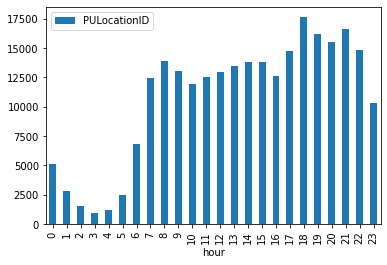

In [29]:
hour_group = day_taxi_lite.groupby('hour')[['PULocationID']].count()
hour_group.plot(kind='bar')
plt.savefig('hour_hist_3.png')

In [42]:
def get_trip_counts():
    # make a DataFrame with locations for each bike station
    locations = taxi_lite.groupby("PULocationID").first()
    locations = locations.loc[:, []]
    
    #select one time of day
    subset = taxi_lite
    
    # count trips for each origin
    departure_counts =  subset.groupby("PULocationID").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["PickUp Count"]
    
    # count trips for each destination
    arrival_counts =  subset.groupby("DOLocationID").count().iloc[:,[0]]
    arrival_counts.columns= ["DropOff Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts
get_trip_counts().head()

,PickUp Count,DropOff Count
PULocationID,,
1,720,16540
2,18,8
3,158,618
4,12714,32712
5,16,32


In [33]:
# data preprocessing -- groupby stations to get departure, arrival counts and lat/lng
def get_trip_counts_by_hour(selected_hour):
    # make a DataFrame with locations for each bike station
    locations = taxi_lite.groupby("PULocationID").first()
    locations = locations.loc[:, []]
    
    #select one time of day
    subset = taxi_lite[taxi_lite["hour"]==selected_hour]
    
    # count trips for each origin
    departure_counts =  subset.groupby("PULocationID").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["PickUp Count"]
    
    # count trips for each destination
    arrival_counts =  subset.groupby("DOLocationID").count().iloc[:,[0]]
    arrival_counts.columns= ["DropOff Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts
get_trip_counts_by_hour(6).head()

,PickUp Count,DropOff Count
PULocationID,,
1,31,993.0
3,14,16.0
4,229,245.0
7,653,446.0
8,4,7.0


In [60]:
week_mask = (taxi_lite['pickuptime'] >= '2019-5-6') & (taxi_lite['pickuptime'] < '2019-5-13')
week_taxi_lite = taxi_lite.loc[week_mask]
week_taxi_lite

,PULocationID,DOLocationID,trip_distance,pickuptime,dropofftime,hour,weekday_name
1320227,161,79,2.64,2019-05-06 00:00:27,2019-05-06 00:10:01,0,Monday
1320384,230,170,1.09,2019-05-06 00:00:33,2019-05-06 00:06:17,0,Monday
1320415,100,263,3.18,2019-05-06 00:00:15,2019-05-06 00:13:47,0,Monday
1321124,132,197,6.88,2019-05-06 00:01:25,2019-05-06 00:14:15,0,Monday
1321175,7,252,8.21,2019-05-06 00:02:51,2019-05-06 00:18:27,0,Monday
...,...,...,...,...,...,...,...
3345182,237,87,6.71,2019-05-12 21:55:58,2019-05-12 22:19:56,21,Sunday
3359081,209,87,0.61,2019-05-12 22:31:03,2019-05-12 22:38:16,22,Sunday
3359082,231,87,0.49,2019-05-12 22:49:52,2019-05-12 22:58:48,22,Sunday
3372496,261,43,6.22,2019-05-12 23:05:41,2019-05-12 23:50:51,23,Sunday


In [61]:
weekday_group = week_taxi_lite.groupby('weekday_name')[['PULocationID']].count()
weekday_group

,PULocationID
weekday_name,
Friday,265638
Monday,227506
Saturday,252413
Sunday,225367
Thursday,270966
Tuesday,250824
Wednesday,257217


In [62]:
weekday_order = ["Monday", "Tuesday", "Wednesday", 
                "Thursday","Friday","Saturday","Sunday"]
weekday_group.index = pd.CategoricalIndex(weekday_group.index, 
                               categories=weekday_order, 
                               ordered=True)
weekday_group.sort_index()

,PULocationID
weekday_name,
Monday,227506
Tuesday,250824
Wednesday,257217
Thursday,270966
Friday,265638
Saturday,252413
Sunday,225367


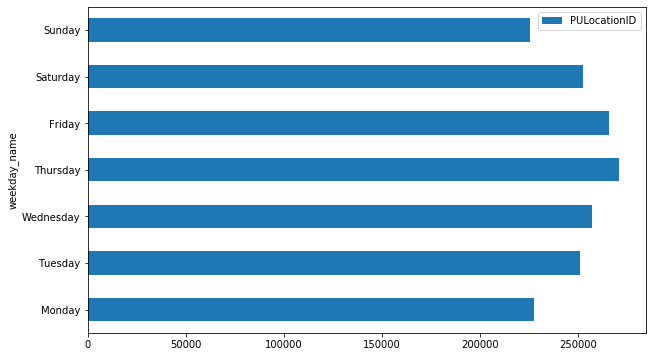

In [80]:
_ = weekday_group.sort_index().plot(kind='barh',figsize = (10,6))
plt.savefig('week_hist.png')

In [40]:
# data preprocessing -- groupby stations to get departure, arrival counts and lat/lng
def get_trip_counts_by_weekday(selected_day):
    # make a DataFrame with locations for each bike station
    locations = week_taxi_lite.groupby("PULocationID").first()
    locations = locations.loc[:, []]
    
    #select one day of week
    subset = week_taxi_lite[week_taxi_lite["weekday_name"]==selected_day]
    
    # count trips for each origin
    departure_counts =  subset.groupby("PULocationID").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["PickUp Count"]
    
    # count trips for each destination
    arrival_counts =  subset.groupby("DOLocationID").count().iloc[:,[0]]
    arrival_counts.columns= ["DropOff Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts
get_trip_counts_by_weekday('Wednesday').head()

,PickUp Count,DropOff Count
PULocationID,,
1,31,498.0
2,1,NaN
3,4,16.0
4,336,1005.0
7,276,795.0


In [ ]:
# data preprocessing -- groupby stations to get departure, arrival counts and lat/lng
def get_trip_counts_by_hour(selected_hour):
    # make a DataFrame with locations for each bike station
    locations = bike_data.groupby("start station id").first()
    locations = locations.loc[:, ["start station latitude",
                                 "start station longitude",
                                 "start station name"]]
    
    #select one time of day
    subset = bike_data[bike_data["hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("start station id").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("end station id").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

In [15]:
# data manually download from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
taxi_zone = gpd.read_file('taxi_zones/taxi_zones.shp')

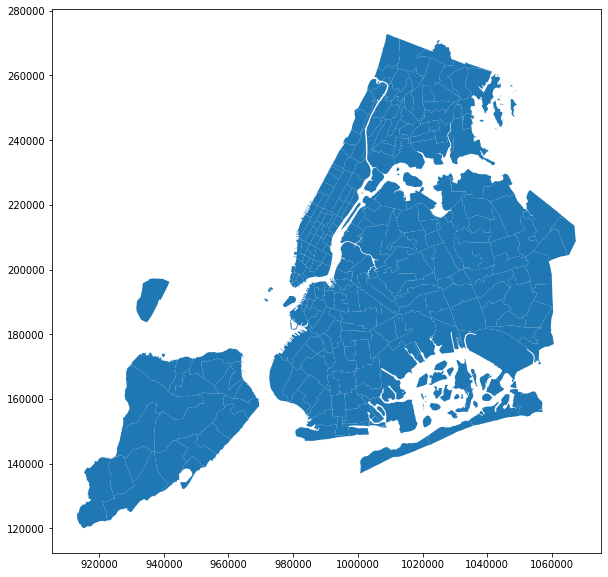

In [81]:
taxi_zone.plot(figsize= (10,10))
plt.savefig('taxi_zone.png')

In [43]:
taxi_zone.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [46]:
taxi_counts_total = get_trip_counts()
taxi_zone_total = taxi_zone.merge(taxi_counts_total,how='left', left_on='LocationID',right_on = 'PULocationID')
taxi_zone_total.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PickUp Count,DropOff Count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",720.0,16540.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",18.0,8.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",158.0,618.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",12714.0,32712.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",16.0,32.0


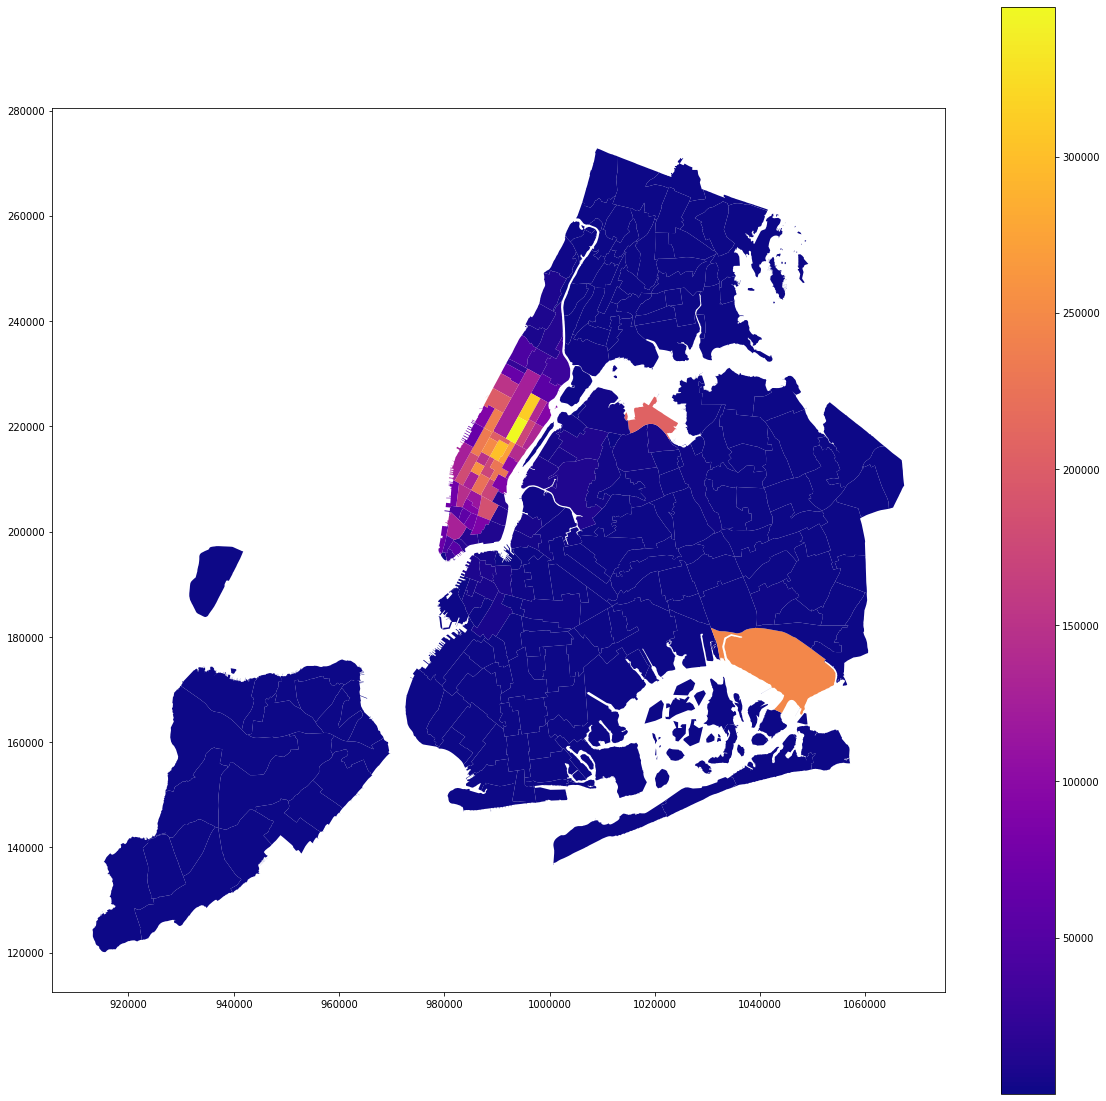

In [82]:
f, ax = plt.subplots(1,1,figsize=(20,20))
taxi_zone_total.dropna(subset=['PickUp Count'], axis=0).plot('PickUp Count', ax=ax, cmap='plasma',legend = True)
plt.savefig('taxi_zone_total.png')

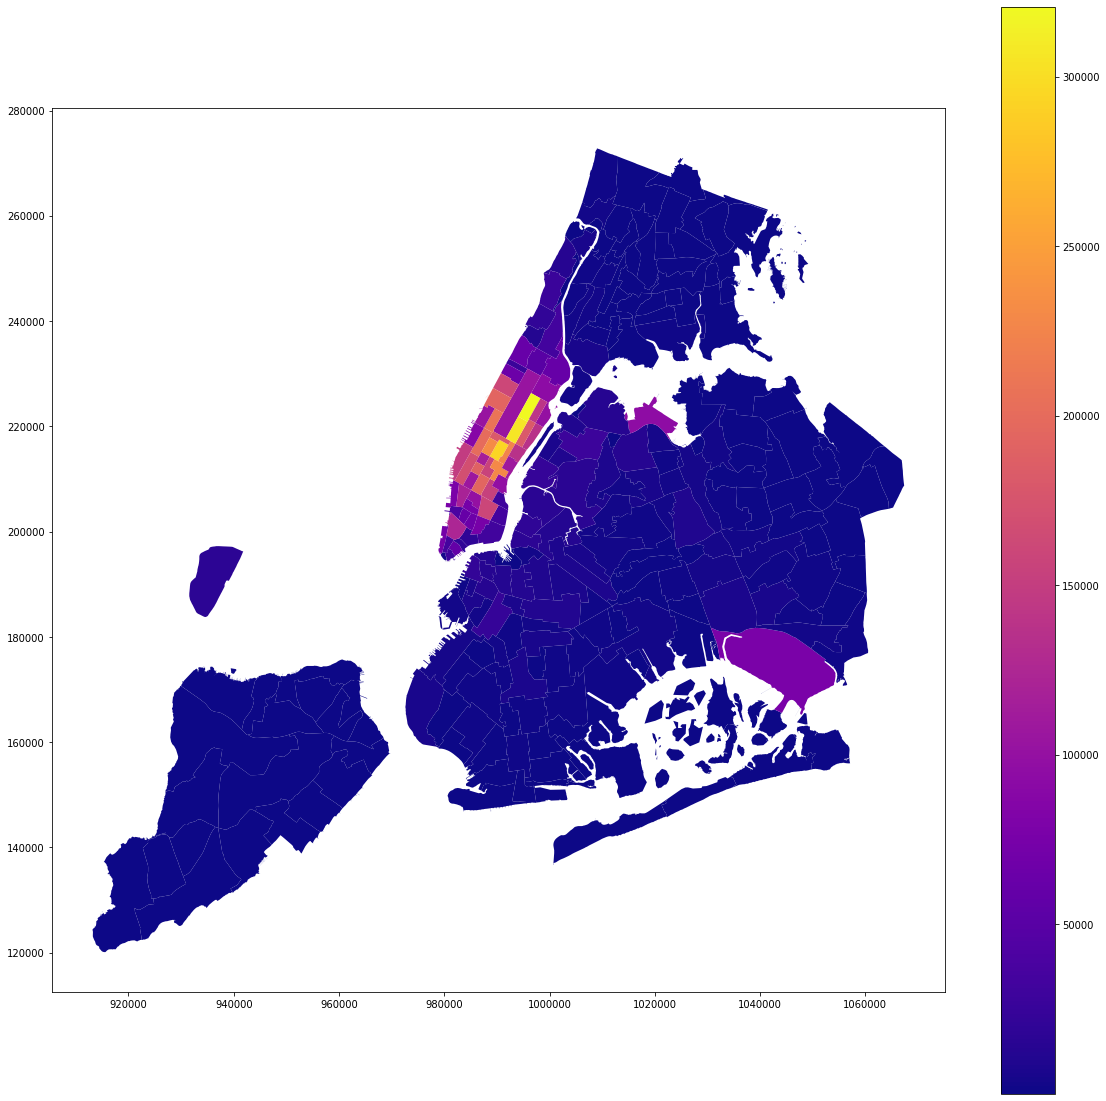

In [83]:
f, ax = plt.subplots(1,1,figsize=(20,20))
taxi_zone_total.dropna(subset=['DropOff Count'], axis=0).plot('DropOff Count', ax=ax, cmap='plasma',legend = True)
plt.savefig('taxi_zone_total_drop.png')

In [71]:
wed_trips = get_trip_counts_by_weekday('Wednesday')
sun_trips = get_trip_counts_by_weekday('Sunday')

In [72]:
taxi_zone_wed = taxi_zone.merge(wed_trips,how='left', left_on='LocationID',right_on = 'PULocationID')
taxi_zone_sun = taxi_zone.merge(sun_trips,how='left', left_on='LocationID',right_on = 'PULocationID')
taxi_zone_wed.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PickUp Count,DropOff Count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",24.0,594.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",8.0,6.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",3.0,19.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",279.0,908.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",1.0,1.0


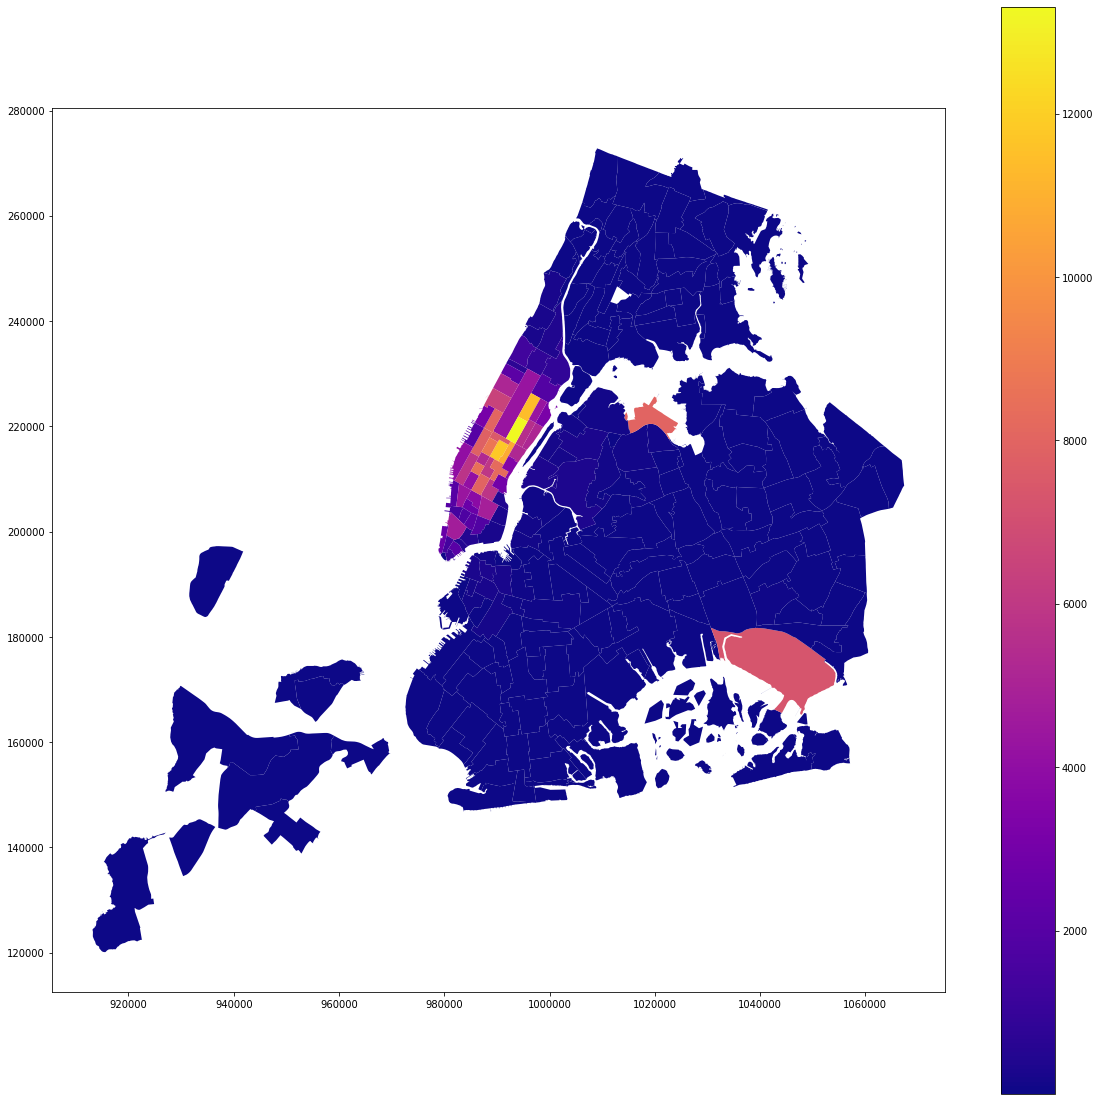

In [84]:
f, ax = plt.subplots(1,1,figsize=(20,20))
taxi_zone_wed.dropna(subset=['PickUp Count'], axis=0).plot('PickUp Count', ax=ax, cmap='plasma',legend = True)
plt.savefig('taxi_zone_wed.png')

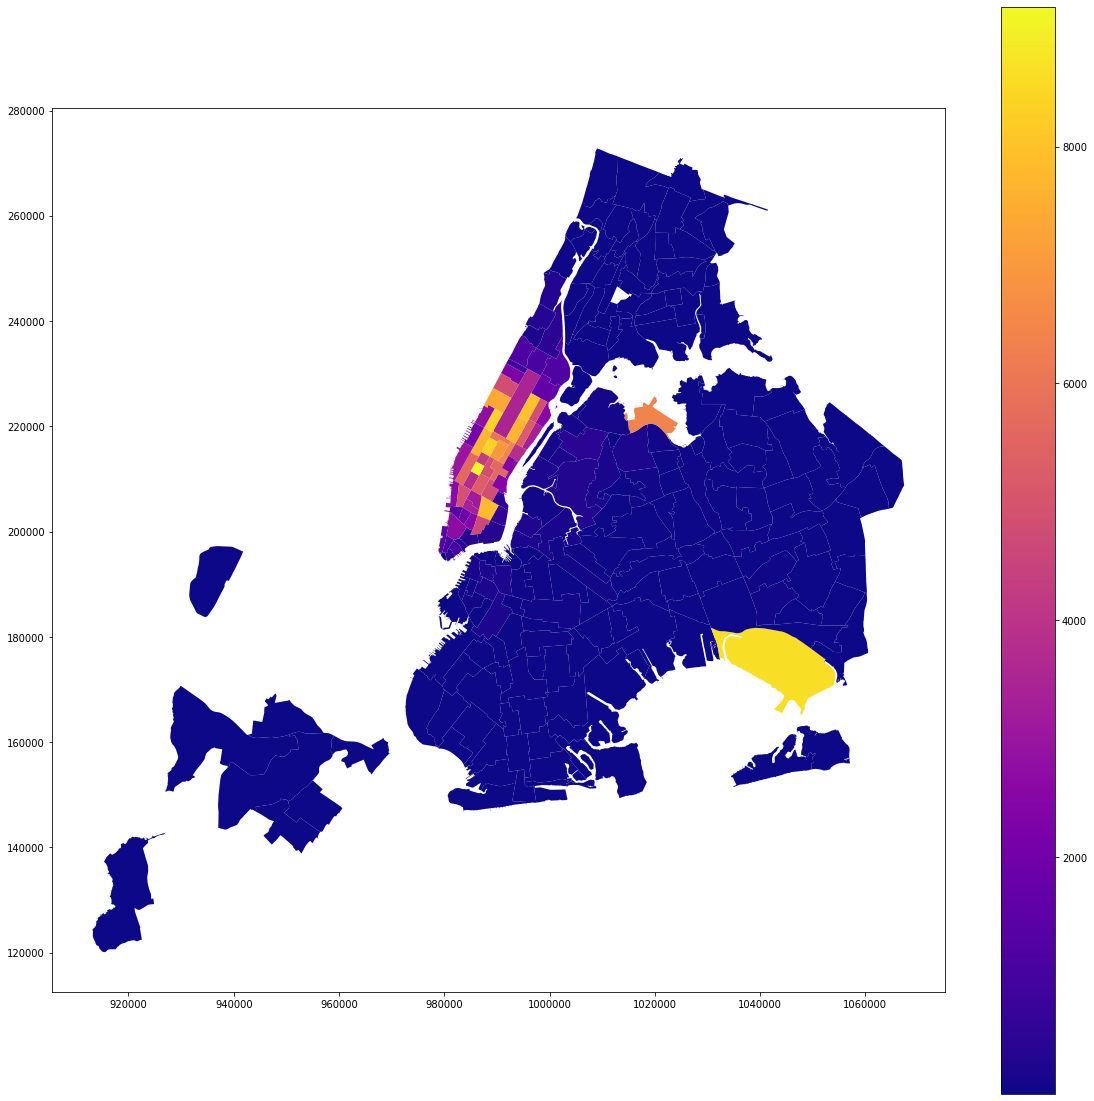

In [85]:
f, ax = plt.subplots(1,1,figsize=(20,20))
taxi_zone_sun.dropna(subset=['PickUp Count'], axis=0).plot('PickUp Count', ax=ax, cmap='plasma',legend = True)
plt.savefig('taxi_zone_sun.png')

In [75]:
hour6_trips = get_trip_counts_by_hour(6)
hour18_trips = get_trip_counts_by_hour(18)

In [76]:
taxi_zone_hour6 = taxi_zone.merge(hour6_trips,how='left', left_on='LocationID',right_on = 'PULocationID')
taxi_zone_hour18 = taxi_zone.merge(hour18_trips,how='left', left_on='LocationID',right_on = 'PULocationID')
taxi_zone_hour6.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PickUp Count,DropOff Count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",31.0,993.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",14.0,16.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",229.0,245.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",NaN,NaN


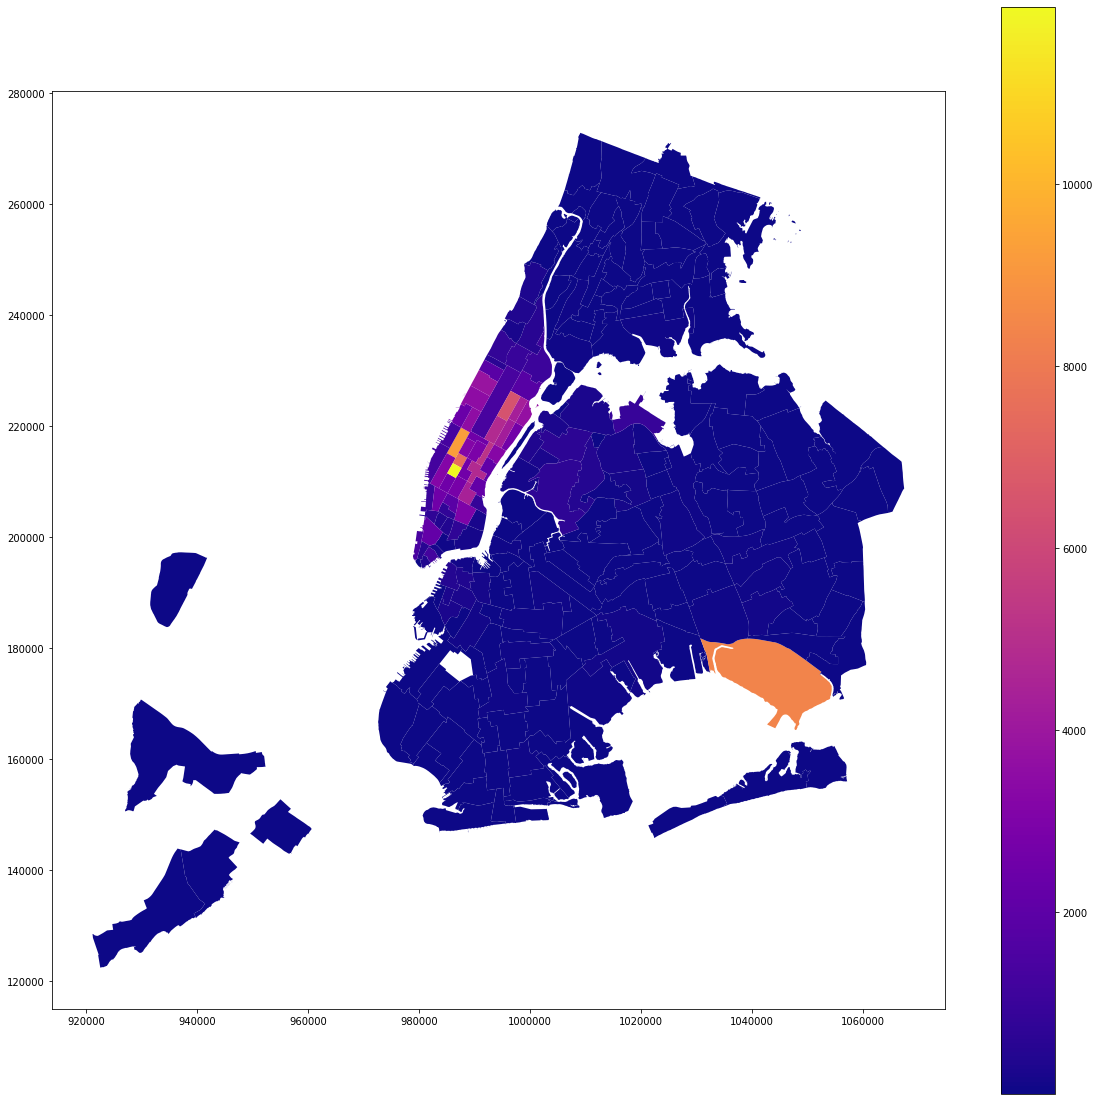

In [86]:
f, ax = plt.subplots(1,1,figsize=(20,20))
taxi_zone_hour6.dropna(subset=['PickUp Count'], axis=0).plot('PickUp Count', ax=ax, cmap='plasma',legend = True)
plt.savefig('taxi_zone_hour6.png')

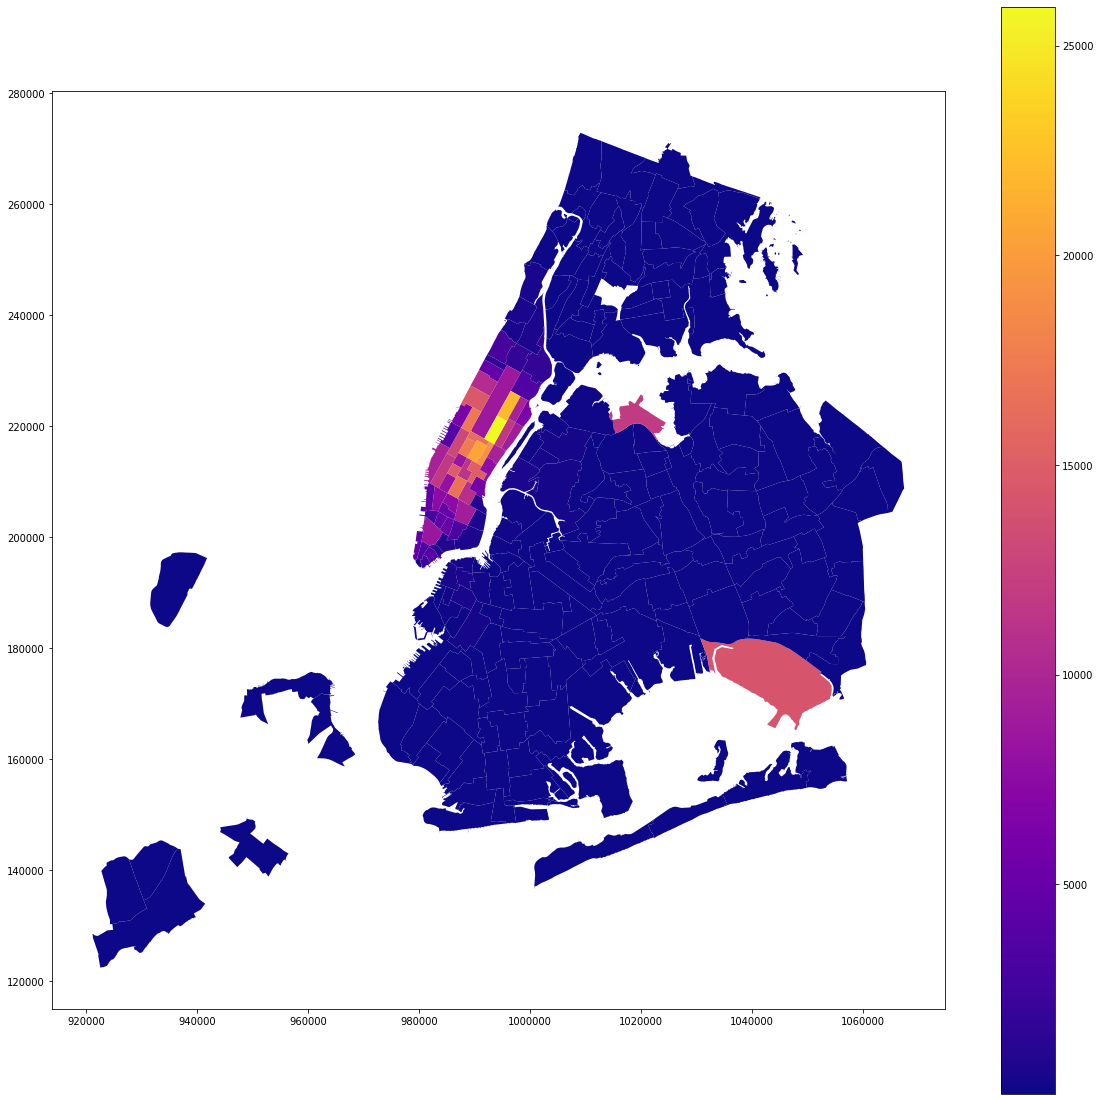

In [87]:
f, ax = plt.subplots(1,1,figsize=(20,20))
taxi_zone_hour18.dropna(subset=['PickUp Count'], axis=0).plot('PickUp Count', ax=ax, cmap='plasma',legend = True)
plt.savefig('taxi_zone_hour18.png')